# plateSolve Example

This notebook will show you how to use the plateSolve package.

Let's start with setup - you'll need to import it something like this (note the sys.path.append). The other packages may be useful or will be necessary

In [6]:
%matplotlib inline
import sys
sys.path.append('/home/idies/workspace/Storage/treed28/persistent/homework_assignments/')
import plateSolve
from astropy.nddata import CCDData
import ccdproc
import os
from pathlib import Path

datadir = '/home/idies/workspace/Temporary/treed28/scratch/20240903/reduced/'
#datadir = '/home/idies/workspace/Storage/treed28/persistent/bin/'
path = Path(datadir)
os.chdir(path) #Note the routines have only been tested when run from inside the 
               #directory holding the images.

# Autosolve

Automatic solving should be as simple as passing the `plateSolve.autoSolve` function the name and CCDData object for the image.

In [7]:
# Does this cell of script need to select all of the filters for the specified file?
# Choose one of the reduced images; preferably R or V, not so much B.

image_name = 'TB_M31-001R_reduced.fit'
image_ccd = CCDData.read(image_name,unit='adu')

check = plateSolve.autoSolve(image_name,image_ccd)
print("Check should be true if autoSolve worked correctly.")
print(image_name,check)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
Check should be true if autoSolve worked correctly.
TB_M31-001R_reduced.fit False


If successful, this should have created an image file that ends with .wcs.fit 
instead of just .fit, as well as a bunch of files that were created along the
way and aren't much use beyond that. We can delete them.

In [8]:
import os
from astropy.io import fits
from astropy.nddata import CCDData

# Define the directory containing the FITS files
fits_directory = '/home/idies/workspace/Temporary/treed28/scratch/20240903/reduced/'

# Loop over all files in the directory ending with .fit
for filename in os.listdir(fits_directory):
    if filename.startswith('TB_M31') and filename.endswith('_reduced.fit'):
        file_path = os.path.join(fits_directory, filename)

        # Load the FITS file as a CCDData object
        image_ccd = CCDData.read(file_path, unit='adu')

        # Perform plate solving on the image
        check = plateSolve.autoSolve(file_path, image_ccd)

        # Print the result of the plate solving operation
        print(f"Plate solving {'succeeded' if check else 'failed'} for {filename}")

        # Prepare the output filename with the '.wcs.fit' extension
        output_filename = os.path.splitext(filename)[0] + '.wcs.fit'
        output_path = os.path.join(fits_directory, output_filename)

        # Save the solved image with the new filename
        image_ccd.write(output_path, overwrite=True)

        #print(f"Saved WCS-corrected file as: {output_filename}")


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Error in plate solve, stopping before creating wcs solved image.
Plate solving failed for TB_M31-001B_reduced.fit
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
Plate solving failed for TB_M31-001R_reduced.fit
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Plate solving succeeded for TB_M31-001V_reduced.fit


In [9]:
if check==True:
    plateSolve.cleanup(image_name)
    
    #With default arguments, this just warns you.
    #Uncomment the next line if you are happy deleting the files
    #plateSolve.cleanup(image_name,check=False)

Deleting the following files:
['TB_M31-001R_reduced.gaia.proj', 'TB_M31-001R_reduced.stars.csv', 'TB_M31-001R_reduced.gaia.csv', 'TB_M31-001R_reduced.match.transform']
If you want to delete the files, rerun this command with check=False


# Using WCS 

We can now use the WCS information in the header of the new image tot do conversions between RA,dec and pixels, and vice versa.

In [11]:
import os
from astropy.io import fits
from astropy import wcs
import warnings

# Ignore warnings
warnings.simplefilter("ignore")

# Define the directory containing the .wcs.fit files
fits_directory = '/home/idies/workspace/Temporary/treed28/scratch/20240903/reduced/'

# Loop through all files in the directory that end with .wcs.fit
for filename in os.listdir(fits_directory):
    if filename.endswith('.wcs.fit'):
        file_path = os.path.join(fits_directory, filename)

        # Open the FITS file
        with fits.open(file_path) as d:
            # Extract WCS information from the header
            wcsobj = wcs.WCS(d[0].header)

            # Example: Convert pixel coordinates (100, 100) to sky coordinates (RA, Dec)
            sky = wcsobj.pixel_to_world(100, 100)

            # Print the result
            print(f"Sky coordinates for {filename}: {sky}")


Sky coordinates for TB_M31-001R_reduced.wcs.fit: [<Quantity 101.>, <Quantity 101.>]
Sky coordinates for TB_M31-001V_reduced.wcs.fit: [<Quantity 101.>, <Quantity 101.>]
Sky coordinates for TB_M31-001B_reduced.wcs.fit: [<Quantity 101.>, <Quantity 101.>]


# Manual Solve

The crossmatching used by autosolve is tempramental, and you may need to manually choose a list of stars for the plate solver to work with.

You can do this using the `plateSolve.manualSolvePlot` command to plot lists of stars to match up,
and `plateSolve.manualSolve` to perform the solve,

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
TB_M31-001R_reduced.fit False
2740.61136841242 118.48134895266068
2440.749565511712 3406.8082754229754


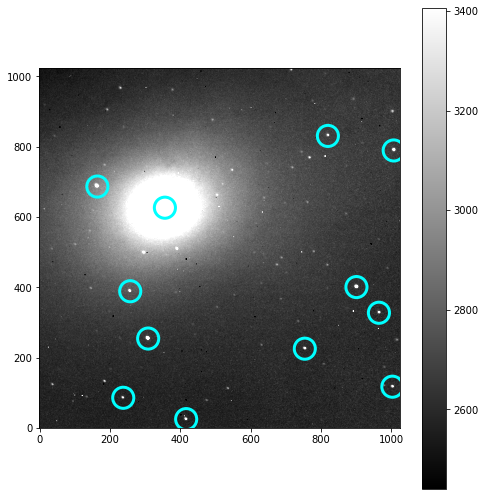

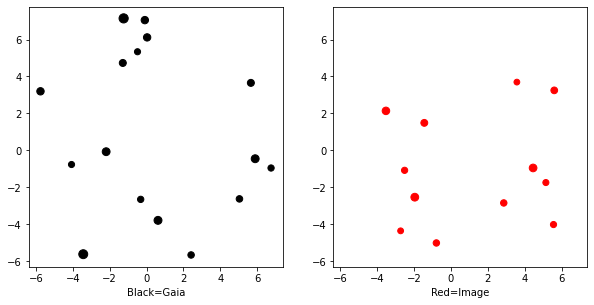

In [13]:
image_name = 'TB_M31-001R_reduced.fit'
image_ccd = CCDData.read(image_name,unit='adu')

check = plateSolve.autoSolve(image_name,image_ccd,threshold=10,gaiaMagLimit=14.0) 
#I increased the starfind threshold to cut down on the number of stars detected
print(image_name,check)

#You need to have run autosolve first before 
#you can run the manual commands
#Let's assume the autoSolve failed, which isn't the case here.

#First, plot the image and reference star catalogs
plateSolve.manualSolvePlot(image_name,image_ccd)

In [ ]:
help (plateSolve.autoSolve)

Next look for asterisms that match between the Gaia catalog on the right, and stars found in the image on the left. Hover over the image to show the star ID numbers. You can use the marked stars on the image above to check if they are real or not. The more the better, but only include star you are sure you are in both lists if possible. You need at least 4 stars for a successful first order plateSolve, or 7 for a second order solve.

Make two lists of the stars that you are sure match up - one for Gaia, one for the image. Then run the `manualSolve`

In [14]:
gaia_list = [4,12,2,11,10,13,3,9]
image_list = [2,7,0,6,5,9,1,11]

check = plateSolve.manualSolve(image_name,image_ccd,gaia_list,image_list,grmatch_order=1)
print("Check is True if successful")
print(image_name,check)

Check is True if successful
TB_M31-001R_reduced.fit True


# Harder to solve cases

There are lots of variables you can tweak to try to fix a plate solve that won't work. You can list them all via the help function for autoSolve. Using the optional argument verbose=1 or higher will produce more output that can help diagnose a problem.

In [ ]:
help(plateSolve.autoSolve)

In [ ]:
help(plateSolve.manualSolve)